# Анализ событий на сайте магазина электроники за 5 месяцев

---
## 1. Введение  
**Данные:** события просмотров, «добавление в корзину», покупки.  
- **Источник данных:** https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store

**Задачи:** 
> 1) **Первичный обзор данных**, для выявления особенностей данного датасета.
> 2) **Предобработка**, нахождение лишних данных и очистка датасета.
> 3) **EDA** и краткий анализ.
> 4) **Построение воронки** и анализ её эффективности.
> 5) Более глубокий **анализ категорий и брендов**.

---
## 2. Импорт библиотек и настройка окружения  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Настройки отображения
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')

---
## 3. Загрузка и первичный обзор данных

In [ ]:
# Загрузка датасета для анализа
df = pd.read_csv('events.csv')

# Приведение event_time к naive datetime
df['event_time'] = pd.to_datetime(df['event_time'], utc=True) \
.dt.tz_convert('UTC') \
.dt.tz_localize(None)

In [3]:
# Первичный осмотр данных
df.info()

print(f'\nРазмерность данных {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_time     885129 non-null  datetime64[ns]
 1   event_type     885129 non-null  object        
 2   product_id     885129 non-null  int64         
 3   category_id    885129 non-null  int64         
 4   category_code  648910 non-null  object        
 5   brand          672765 non-null  object        
 6   price          885129 non-null  float64       
 7   user_id        885129 non-null  int64         
 8   user_session   884964 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 60.8+ MB

Размерность данных (885129, 9)


In [4]:
# Первые строки
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [5]:
# Последние строки
df.tail(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
885124,2021-02-28 23:55:01,view,953226,2144415927553229037,NaN,NaN,219.94,1515915625611023730,FRLqIttxKU
885125,2021-02-28 23:58:05,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma
885126,2021-02-28 23:58:09,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd
885127,2021-02-28 23:58:14,view,888273,2144415921932861531,electronics.telephone,NaN,10.16,1515915625611024030,9pCbKMIcSx
885128,2021-02-28 23:59:09,view,743182,2144415935631458761,construction.tools.soldering,kada,65.08,1515915625556087775,BejOXRngEW


In [6]:
# Статистика по числовым признакам
df.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.554165e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [7]:
# Присутствующие типы событий
unique_types = df['event_type'].unique()
print("Уникальные event_type:", unique_types)

Уникальные event_type: ['view' 'cart' 'purchase']


### Выводы и рекомендации
- Не самый обширный набор параметров в данных, но даже тут можно произвести анализ, который сможет улучшить KPI и **увеличить прибыль** представленного магазина.

---
## 4. Предобработка
1. Дубликаты
2. Пропуски

In [8]:
# 1.1. Доля дубликатов по всему датафрейму
dup_count = df.duplicated().sum()
total_rows = len(df)
print(f"Дубликаты: {dup_count} из {total_rows} строк ({dup_count/total_rows:.1%})")

Дубликаты: 655 из 885129 строк (0.1%)


In [9]:
# 1.2. Удаление дубликатов 
df.drop_duplicates(inplace=True)

In [10]:
# 2.1. Пропуски по каждому столбцу (абсолютно и в %)
missing = df.isnull().sum()
missing_pct = missing / total_rows * 100
missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct.round(1)
})
print("\nПропуски по столбцам:")
print(missing_df)


Пропуски по столбцам:
               missing_count  missing_pct
event_time                 0          0.0
event_type                 0          0.0
product_id                 0          0.0
category_id                0          0.0
category_code         236047         26.7
brand                 212232         24.0
price                      0          0.0
user_id                    0          0.0
user_session             162          0.0


### Выводы и рекомендации
- В данных много пропусков как раз таки в тех полях которые имеют для нас наибольщую ценность для анализа. 
- Такие большие пропуски нельзя игнорировать и работать придется с ними, ведь в остальном анализ например по типу события может быть произведен. 
- И также если иметь доступ к базе с product_id, чтобы иметь представление о продукте скрывающимся за id, то имело бы смысл анализировать конкретные продукты.

---
## 5. Exploratory Data Analysis (EDA)

### 5.1 Краткий обзор активности

Text(0.5, 1.0, 'Частота каждого типа события')

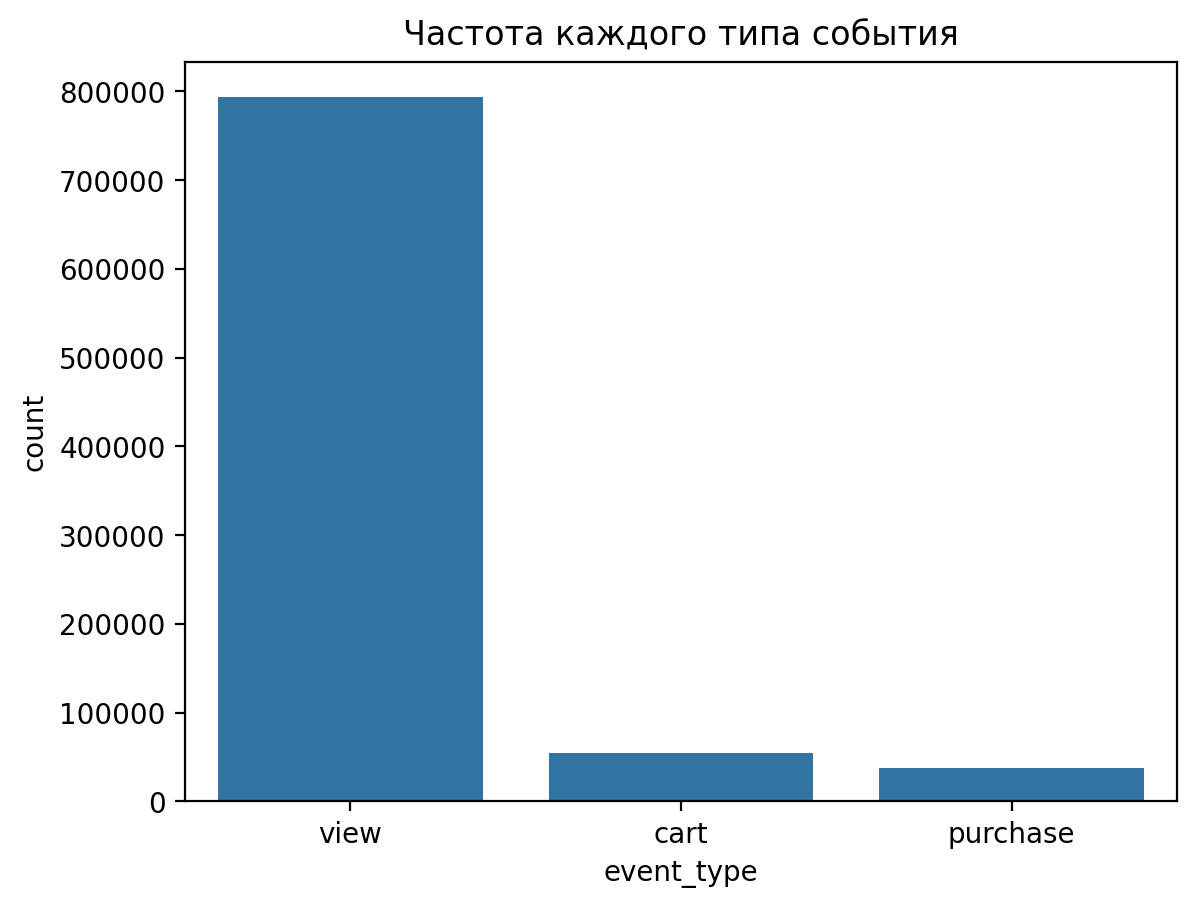

In [11]:
# Распределение событий по типам
sns.countplot(data=df, x='event_type')
plt.title('Частота каждого типа события')

### Выводы и рекомендации
- Даже тут видно, что совсем маленькая часть пользователей добавляет просмотренные товары в корзину и того меньше покупает.
- Далее разберем подробнее, какая часть пользователей делает ключевые действия.

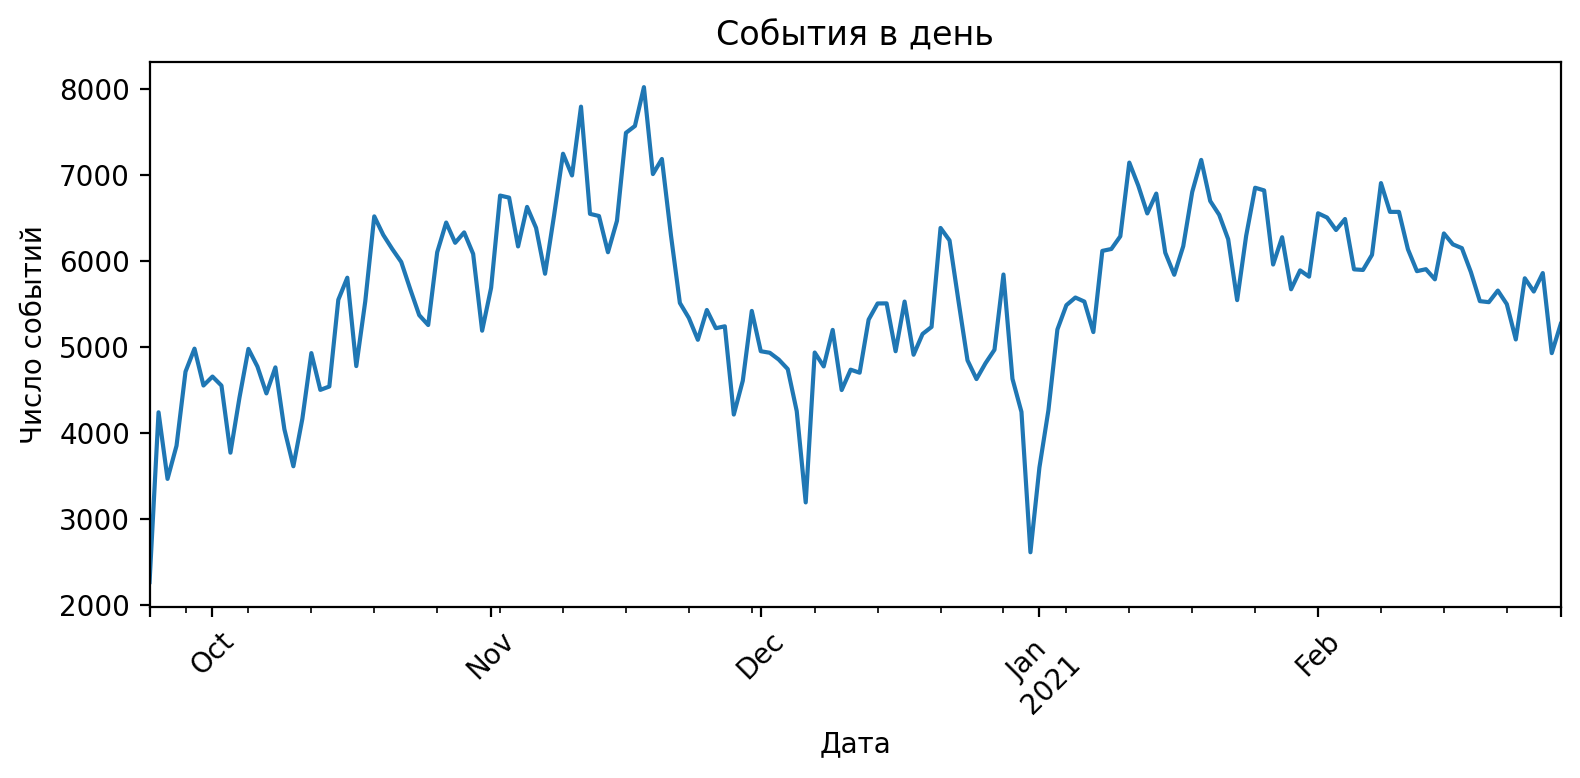

In [12]:
# Временные тренды
daily = df.resample('D', on='event_time')['event_type'].count()

# Рисуем график
fig, ax = plt.subplots(figsize=(8,4))
daily.plot(ax=ax)              
ax.set_title('События в день')      
ax.set_xlabel('Дата')               
ax.set_ylabel('Число событий')      
plt.xticks(rotation=45)             
plt.tight_layout() # чтобы всё уместилось

### Выводы и рекомендации
- Данные всего за 5 месяцев активности, но видно определенный спад в целом после середины ноября.
- Сильнейшие просадки активности в период приближения к Новому году, люди активно заказывают технику за 1.5 месяца до Нового года, чтобы всё точно успело приехать к празднику.
- После праздников активность пришла к своему среднему значению.

### 5.2 Выявление выбросов

In [13]:
# Метод IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)]

# Z-score
df['z_score'] = np.abs(stats.zscore(df['price'].fillna(df['price'].mean())))
outliers_z = df[df['z_score'] > 3]

print(f"Выбросов по IQR: {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")
print(f"Выбросов по Z-score: {len(outliers_z)} ({len(outliers_z)/len(df)*100:.2f}%)")

Выбросов по IQR: 66259 (7.49%)
Выбросов по Z-score: 6037 (0.68%)


### Выводы и рекомендации
- Z-score и IQR вместе дали понять, что в данных присутствуют очень сильные выбросы по цене.
- Стоит пресмотреться к товарам с экстремально высокой ценой, возможно была допущена ошибка, при добавлении товаров на сайт.

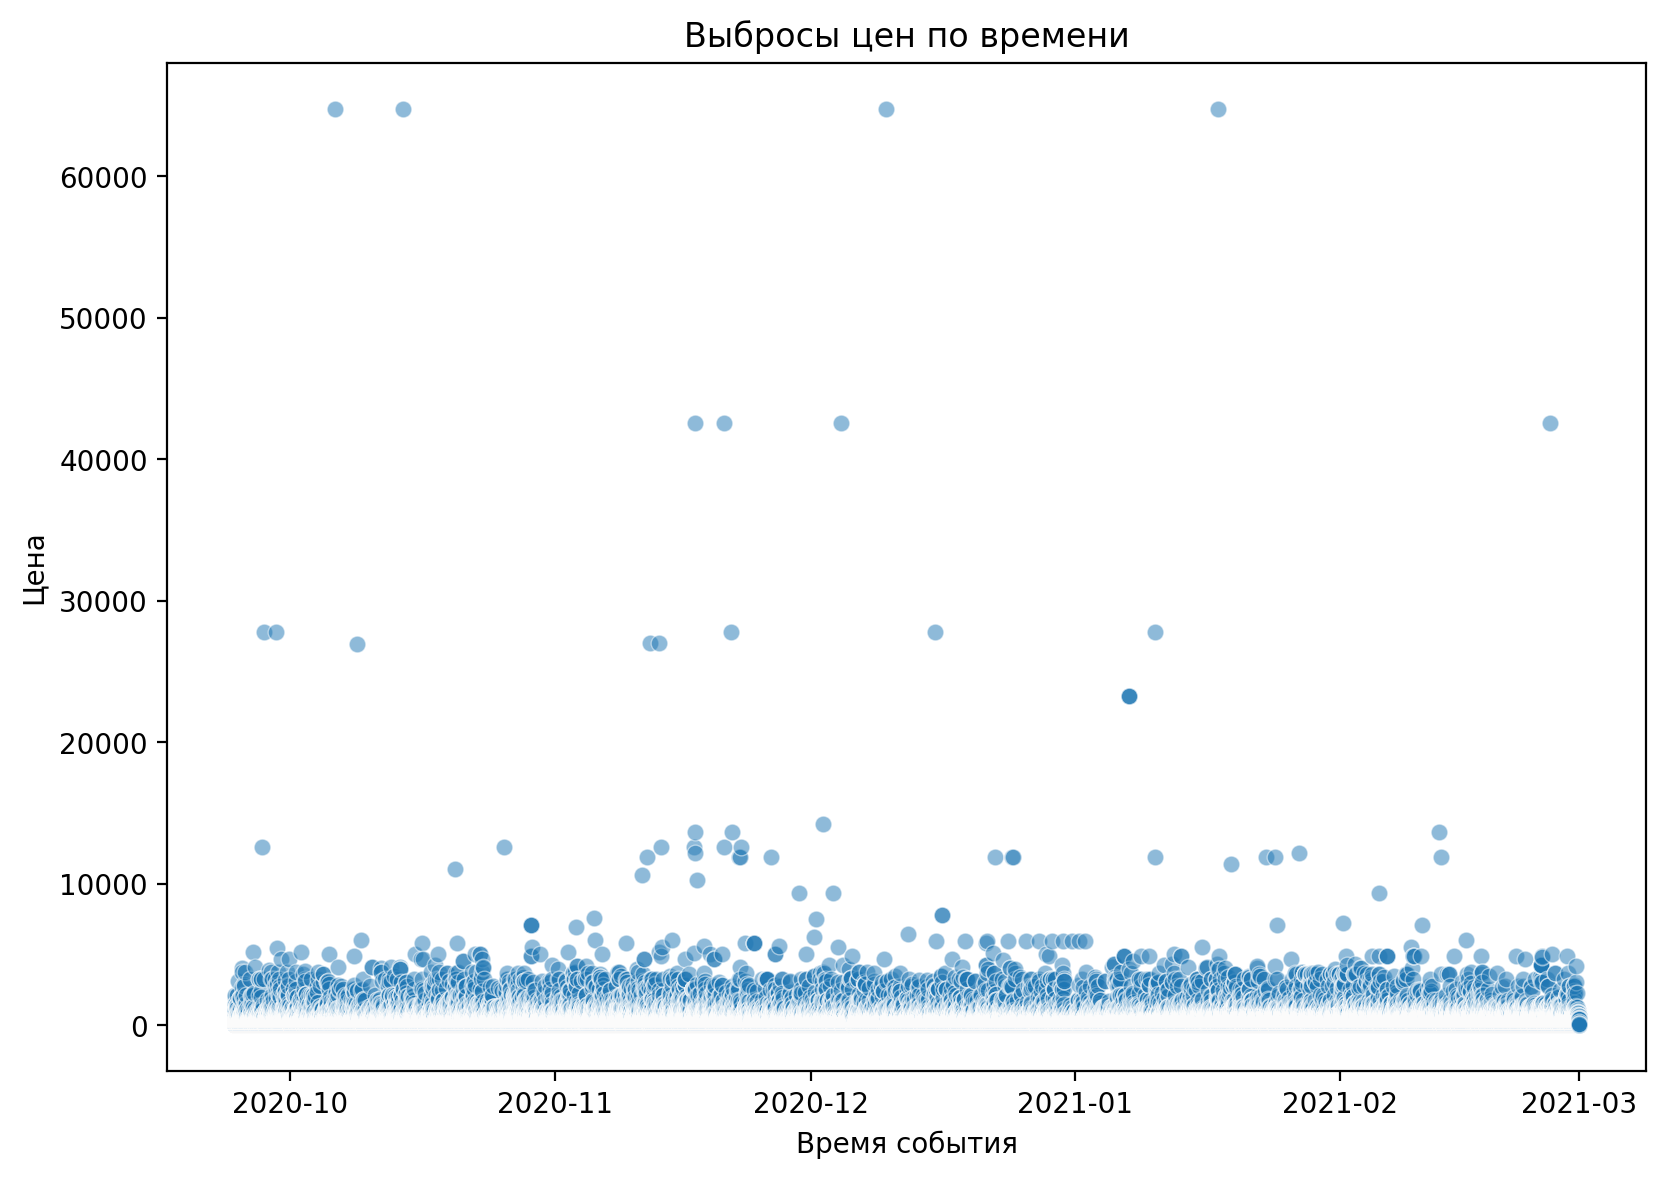

In [14]:
# Визуализация выбросов цен по времени
plt.figure(figsize=(16, 6))  # Ширина 16 дюймов, высота 6 дюймов
plt.subplot(1, 2, 1)
sns.scatterplot(x='event_time', y='price', data=df, alpha=0.5)
plt.title('Выбросы цен по времени')
plt.xlabel('Время события')
plt.ylabel('Цена')

plt.tight_layout()
plt.show()

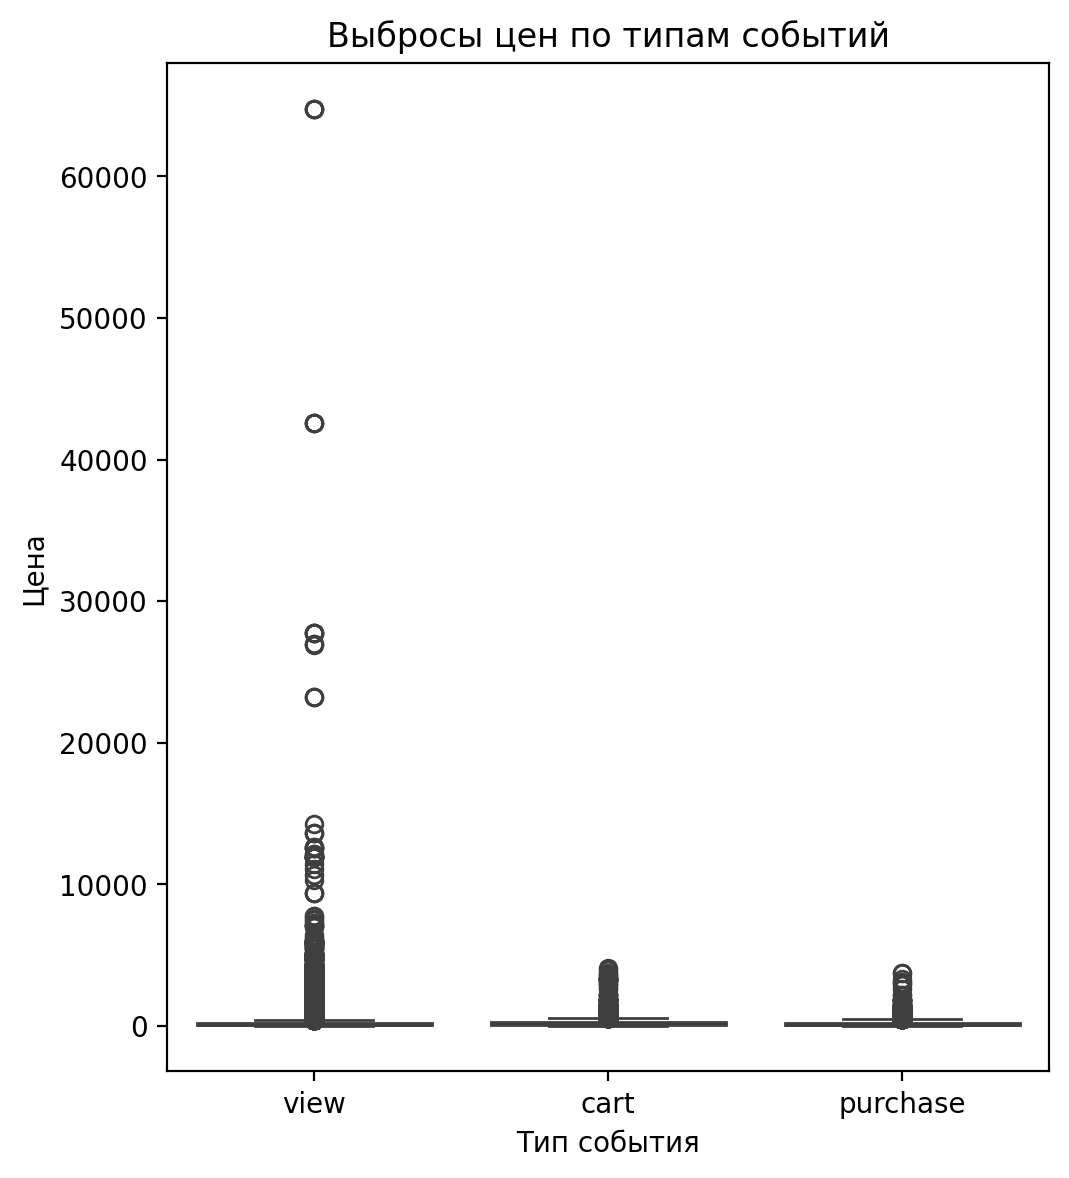

In [15]:
# Визуализация выбросов цен по типам событий
plt.figure(figsize=(10, 6))  # Ширина 16 дюймов, высота 6 дюймов
plt.subplot(1, 2, 2)
sns.boxplot(x='event_type', y='price', data=df)
plt.title('Выбросы цен по типам событий')
plt.xlabel('Тип события')
plt.ylabel('Цена')

plt.tight_layout()
plt.show()

### 5.3 Первичный анализ категорий

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'computers.components.videocards'),
  Text(1, 0, 'electronics.telephone'),
  Text(2, 0, 'computers.peripherals.printer'),
  Text(3, 0, 'stationery.cartrige'),
  Text(4, 0, 'electronics.audio.acoustic')])

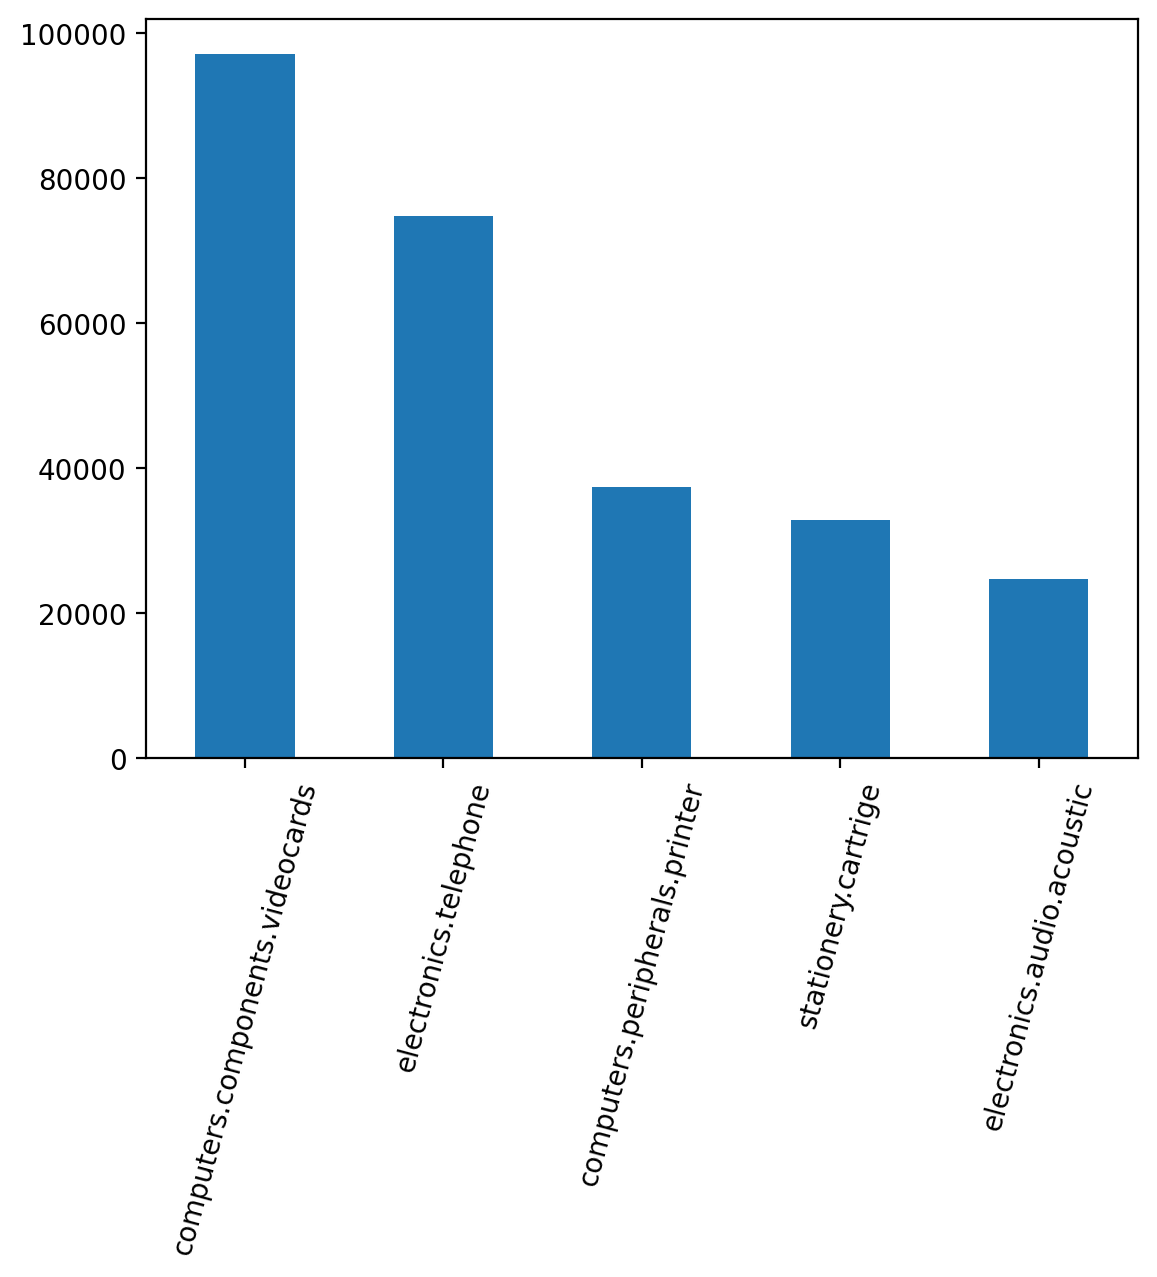

In [ ]:
# Топ категорий по числу просмотров
(df[df.event_type=='view']
   .category_code.value_counts().head(5)
   .plot(kind='bar'))
plt.xticks(rotation=75)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'computers.components.videocards'),
  Text(1, 0, 'electronics.telephone'),
  Text(2, 0, 'stationery.cartrige'),
  Text(3, 0, 'computers.peripherals.printer'),
  Text(4, 0, 'computers.notebook'),
  Text(5, 0, 'computers.components.motherboard'),
  Text(6, 0, 'computers.components.cpu')])

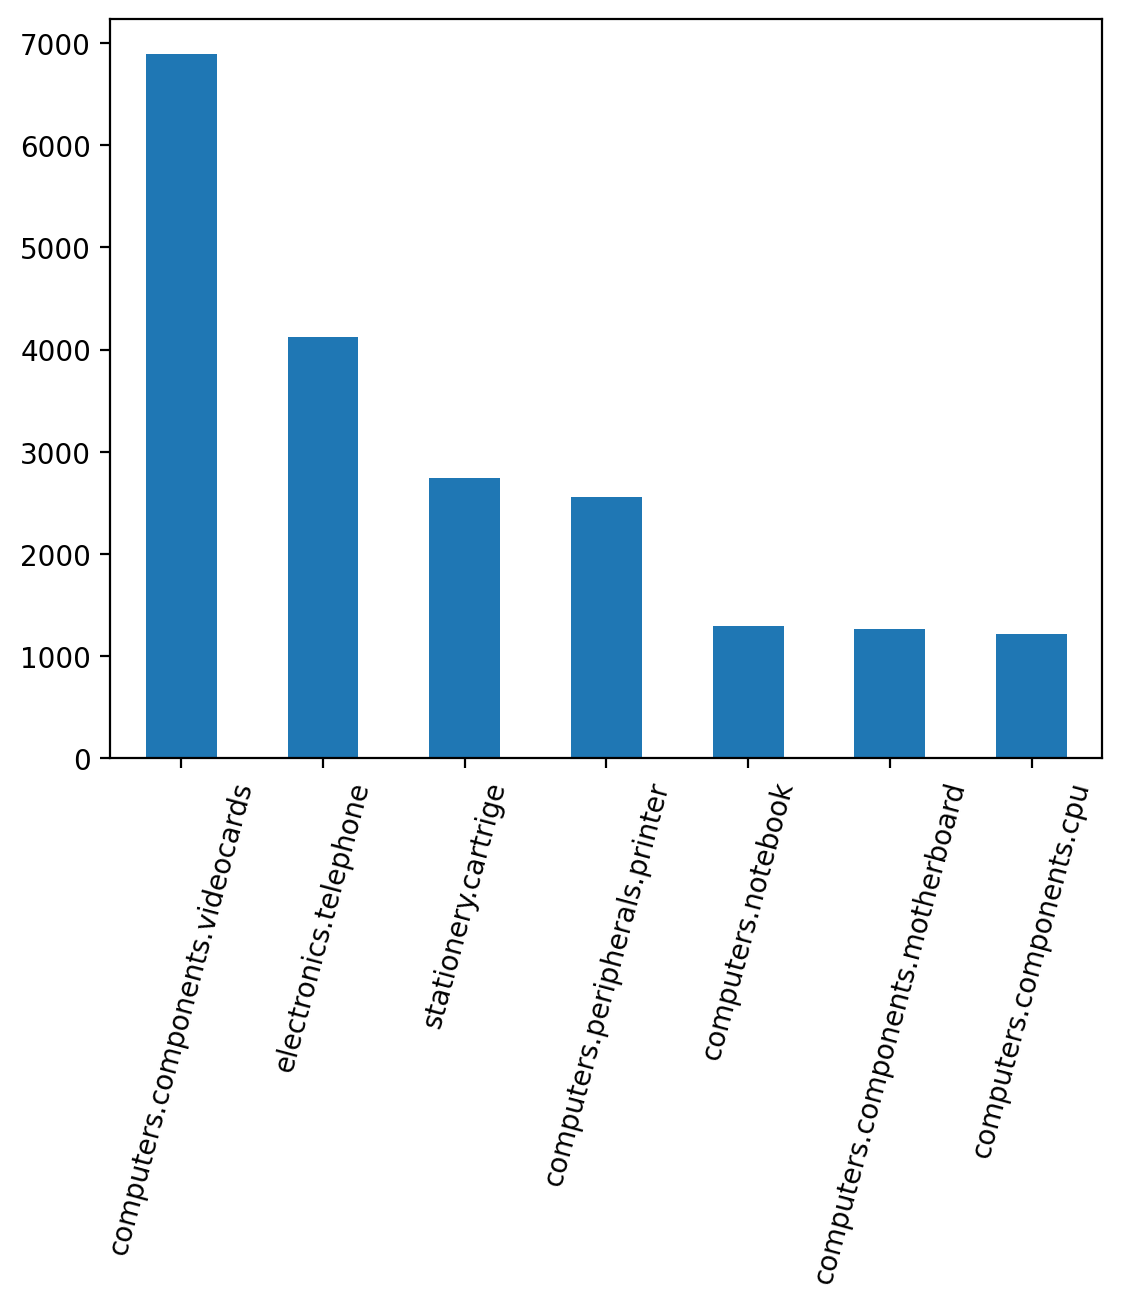

In [ ]:
# Топ категорий по числу покупок
(df[df.event_type=='purchase']
   .category_code.value_counts().head(7)
   .plot(kind='bar'))
plt.xticks(rotation=75)

### Выводы и рекомендации
Сравнив графики просмотров и покупок по **категориям**, можно заметить:
- Много людей смотрят акустику, но совсем не покупают.
- Большой спрос на видеокарты и телефоны.
- Есть смысл сделать фокус на том что уже хорошо продается.
- Выявить почему люди много просматривают акустику но совсем её не покупают. Понять, что их отталкивает и исправить это, ведь это большой нереализованный трафик.

### 5.4 Первичный анализ брендов

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'asus'),
  Text(1, 0, 'gigabyte'),
  Text(2, 0, 'palit'),
  Text(3, 0, 'samsung'),
  Text(4, 0, 'msi'),
  Text(5, 0, 'amd'),
  Text(6, 0, 'canon'),
  Text(7, 0, 'panasonic'),
  Text(8, 0, 'pioneer'),
  Text(9, 0, 'sirius'),
  Text(10, 0, 'hp'),
  Text(11, 0, 'asrock')])

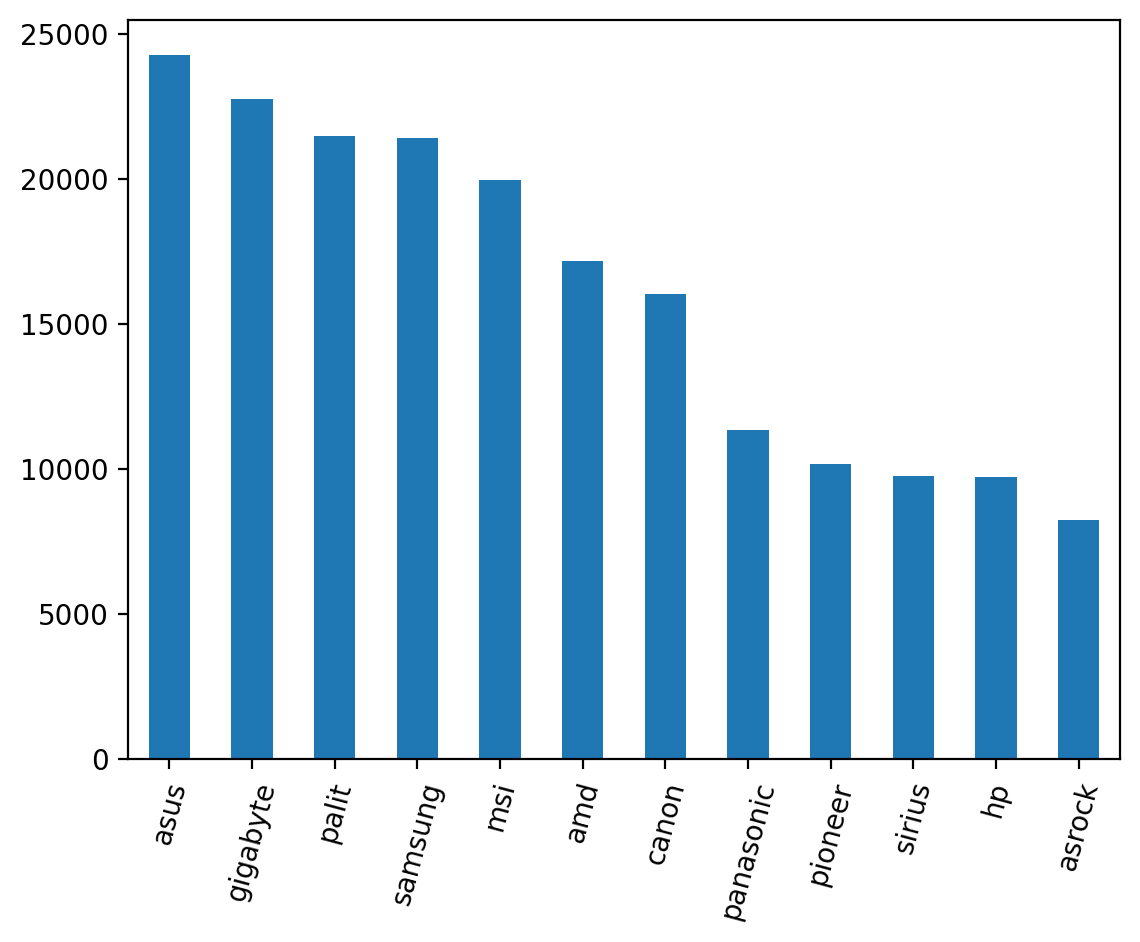

In [28]:
# Топ брендов по числу просмотров
(df[df.event_type=='view']
   .brand.value_counts().head(12)
   .plot(kind='bar'))
plt.xticks(rotation=75)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'msi'),
  Text(1, 0, 'gigabyte'),
  Text(2, 0, 'asus'),
  Text(3, 0, 'palit'),
  Text(4, 0, 'canon'),
  Text(5, 0, 'amd'),
  Text(6, 0, 'sapphire'),
  Text(7, 0, 'samsung'),
  Text(8, 0, 'sirius'),
  Text(9, 0, 'hp')])

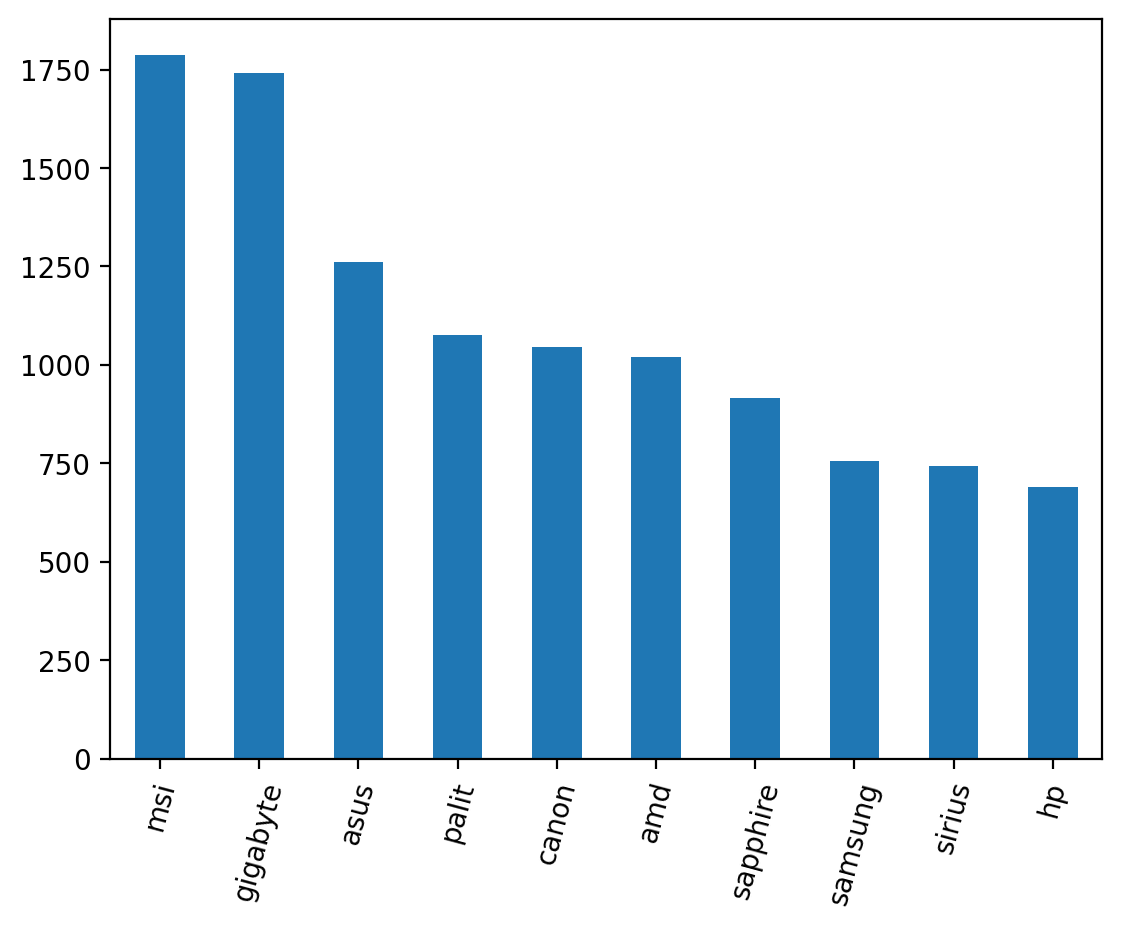

In [ ]:
# Топ брендов по числу покупок
(df[df.event_type=='purchase']
   .brand.value_counts().head(10)
   .plot(kind='bar'))
plt.xticks(rotation=75)

### Выводы и рекомендации
Сравнив графики просмотров и покупок по **брендам**, можно заметить:
- MSI и Gigabyte на голову выше других продаются, а вот по просмотрам MSI занимает не такое высокое место.
- Можно больше предлагать продукцию MSI, ведь её уже готовы активно брать.
- Также стоит поступить с продукцией компании Sapphire, ведь её хорошо берут, а просмотров не набирается даже войти в такой же топ только по просмотрам.
Также не могу не отметить в целом важность улучшения продаж для компаний чья продукция уже хорошо продается:
- Стоит больше предлагать товары этих компаний пользователям.
- Улучшать рекламные компании этих товаров, делать их более интересными и показывающими полезность преобретения.
- Делать процесс покупки всё более простым для пользователя.

---
## 6. Построение воронки

In [20]:
# Формирование флагов прохождения
def mark_steps(g):
    steps = ['view','cart','purchase']
    return pd.Series({f'step_{s}': g.event_type.eq(s).any() for s in steps})

funnel = df.groupby('user_session').apply(mark_steps).reset_index()

In [21]:
# Подсчёт конверсий
counts = funnel.filter(like='step_').sum()
total = len(funnel)

cr = {
    'view→cart':      counts['step_cart']    / counts['step_view']   if counts['step_view']>0   else 0,
    'cart→purchase':  counts['step_purchase']/ counts['step_cart']    if counts['step_cart']>0   else 0,
    'overall':        counts['step_purchase']/ total
}

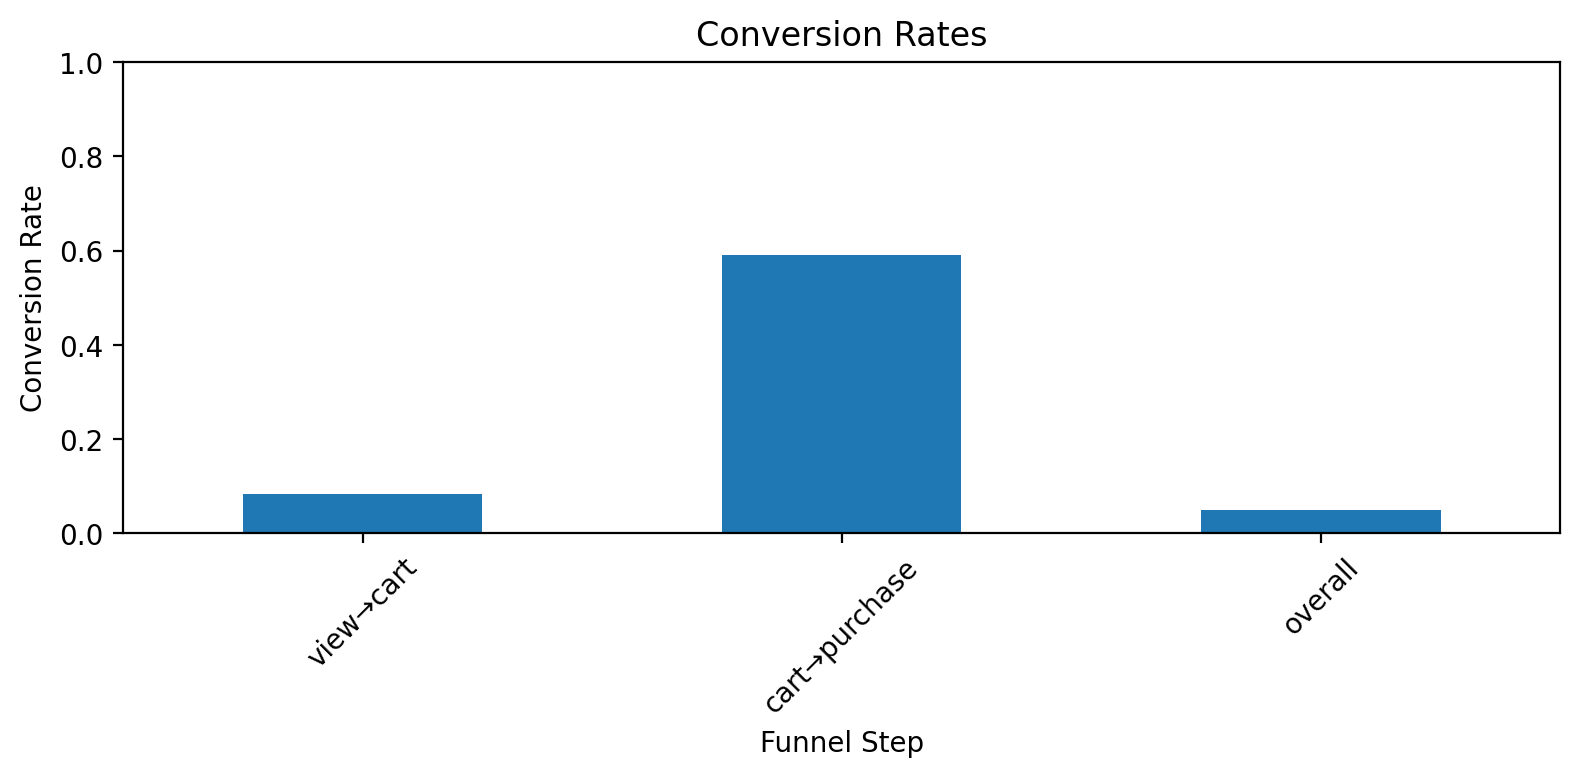

In [22]:
# Строим график
ax = pd.Series(cr).plot(kind='bar', title='Conversion Rates', figsize=(8,4))
ax.set_xlabel('Funnel Step')
ax.set_ylabel('Conversion Rate')
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()

### Выводы и рекомендации
- Только ~10% просмотренных товаров добавляются в корзину.
- А процент покупок и того меньше всего ~5%.
- Но уже неплохой процент выкупа корзины ~60%.
- Стоит усилить интерес пользователей к товарам путем более современного оформления сайта в целом и карточек товаров в частности или например с помощью акций.
- Также имеет смысл упростить процесс покупки или улучшить интерфейс корзины, чтобы пользователю было проще и приятнее купить товар добавленный в корзину.

---
## 7. Сегментация по категориям и брендам

In [23]:
# Привязка основной категории/бренда к сессии
first_view = (df[df.event_type=='view']
              .sort_values('event_time')
              .drop_duplicates('user_session')
              .set_index('user_session')[['category_code','brand']])
funnel = funnel.join(first_view, on='user_session')

### 7.1 Анализ воронки по топ-категориям

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'computers.peripherals.camera'),
  Text(1, 0, 'computers.components.videocards'),
  Text(2, 0, 'computers.peripherals.scanner'),
  Text(3, 0, 'computers.ebooks'),
  Text(4, 0, 'stationery.stapler'),
  Text(5, 0, 'electronics.video.projector'),
  Text(6, 0, 'computers.peripherals.printer'),
  Text(7, 0, 'electronics.audio.dictaphone'),
  Text(8, 0, 'stationery.cartrige'),
  Text(9, 0, 'computers.components.motherboard'),
  Text(10, 0, 'computers.components.power_supply'),
  Text(11, 0, 'electronics.calculator'),
  Text(12, 0, 'computers.components.cdrw'),
  Text(13, 0, 'computers.notebook'),
  Text(14, 0, 'computers.peripherals.wifi')])

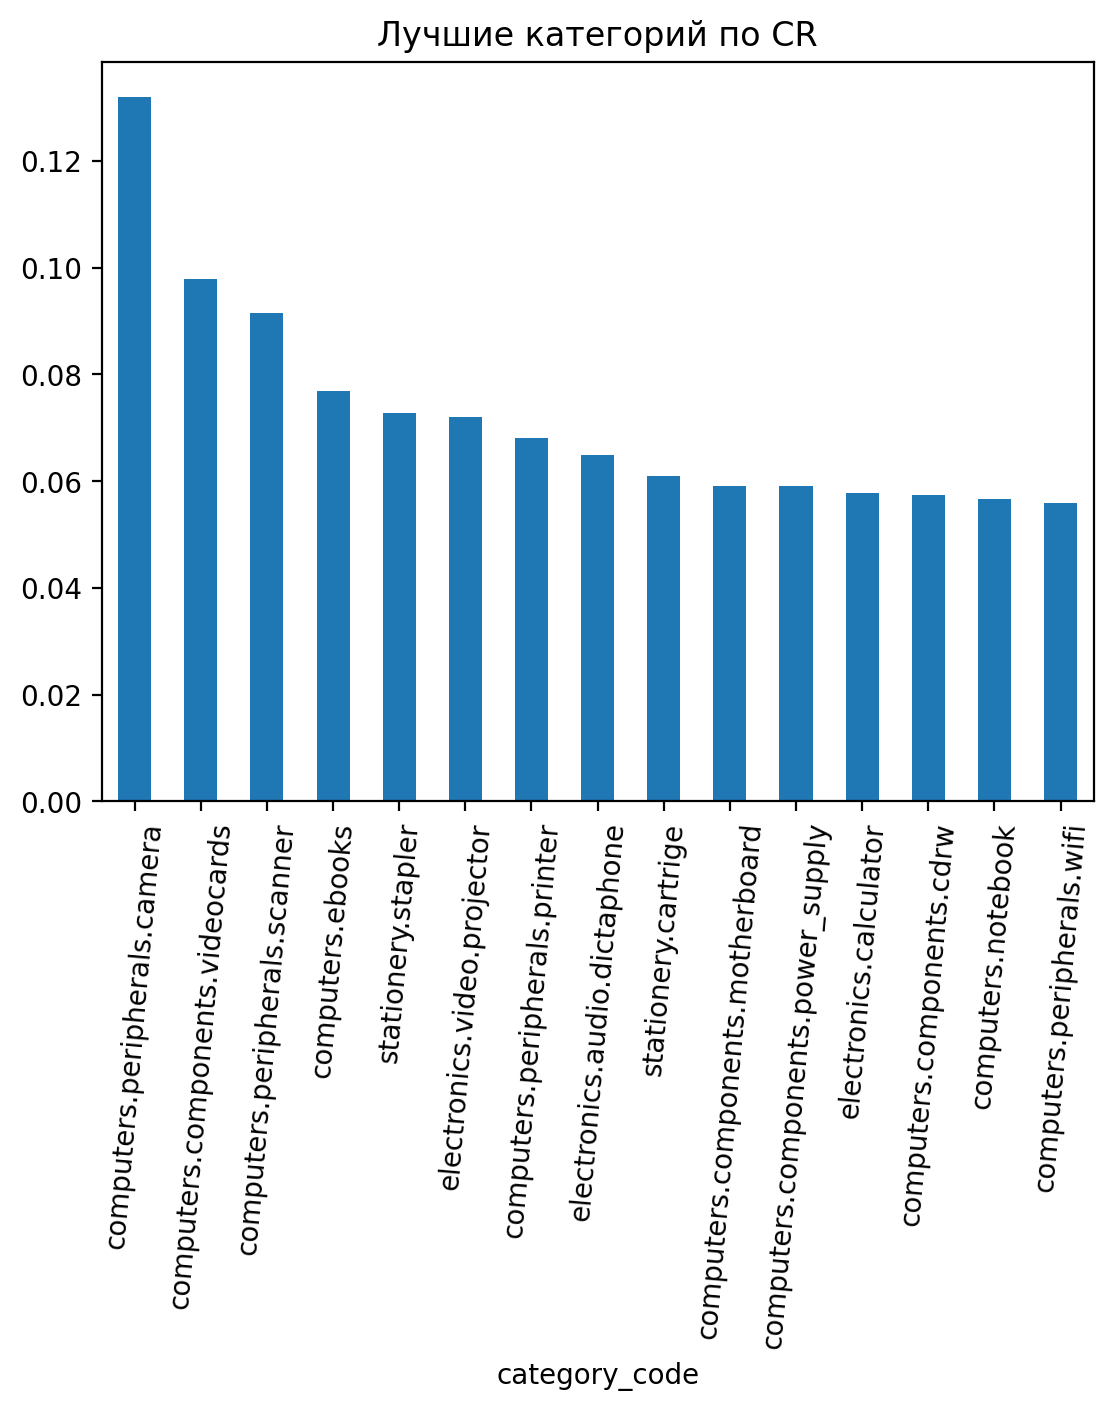

In [38]:
# Визуализация
by_cat = (funnel.groupby('category_code')
          .agg(sessions=('user_session','count'),
               purchases=('step_purchase','sum'))
          .assign(cr=lambda d: d.purchases/d.sessions)
          .sort_values('cr', ascending=False).head(15))
by_cat.cr.plot(kind='bar', title='Лучшие категорий по CR')
plt.xticks(rotation=85)

### Выводы и рекомендации
- Многие категории (особенно камеры), за исключением видеокарт, имеют относительно высокий CR, а вот количество самих покупок относительно мало.
- Можно предлагать больше товаров из этих категорий, за счёт хорошего CR это определенно увеличит продажи -> прибыль.

### 7.2 Анализ воронки по худшим категориям

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'appliances.kitchen.steam_cooker'),
  Text(1, 0, 'electronics.fax'),
  Text(2, 0, 'furniture.kitchen.chair'),
  Text(3, 0, 'appliances.kitchen.washer'),
  Text(4, 0, 'jewelry.ring'),
  Text(5, 0, 'appliances.kitchen.refrigerators'),
  Text(6, 0, 'kids.skates'),
  Text(7, 0, 'furniture.bedroom.blanket'),
  Text(8, 0, 'country_yard.watering'),
  Text(9, 0, 'furniture.bathroom.bath'),
  Text(10, 0, 'appliances.kitchen.coffee_grinder'),
  Text(11, 0, 'construction.tools.generator'),
  Text(12, 0, 'appliances.environment.fan'),
  Text(13, 0, 'auto.accessories.winch'),
  Text(14, 0, 'apparel.glove'),
  Text(15, 0, 'accessories.briefcase'),
  Text(16, 0, 'appliances.kitchen.juicer'),
  Text(17, 0, 'construction.tools.pump'),
  Text(18, 0, 'computers.gaming'),
  Text(19, 0, 'country_yard.cultivator'),
  Text(20, 0, 'appliances.kitchen.coffee_machine'),
  Text(21, 0

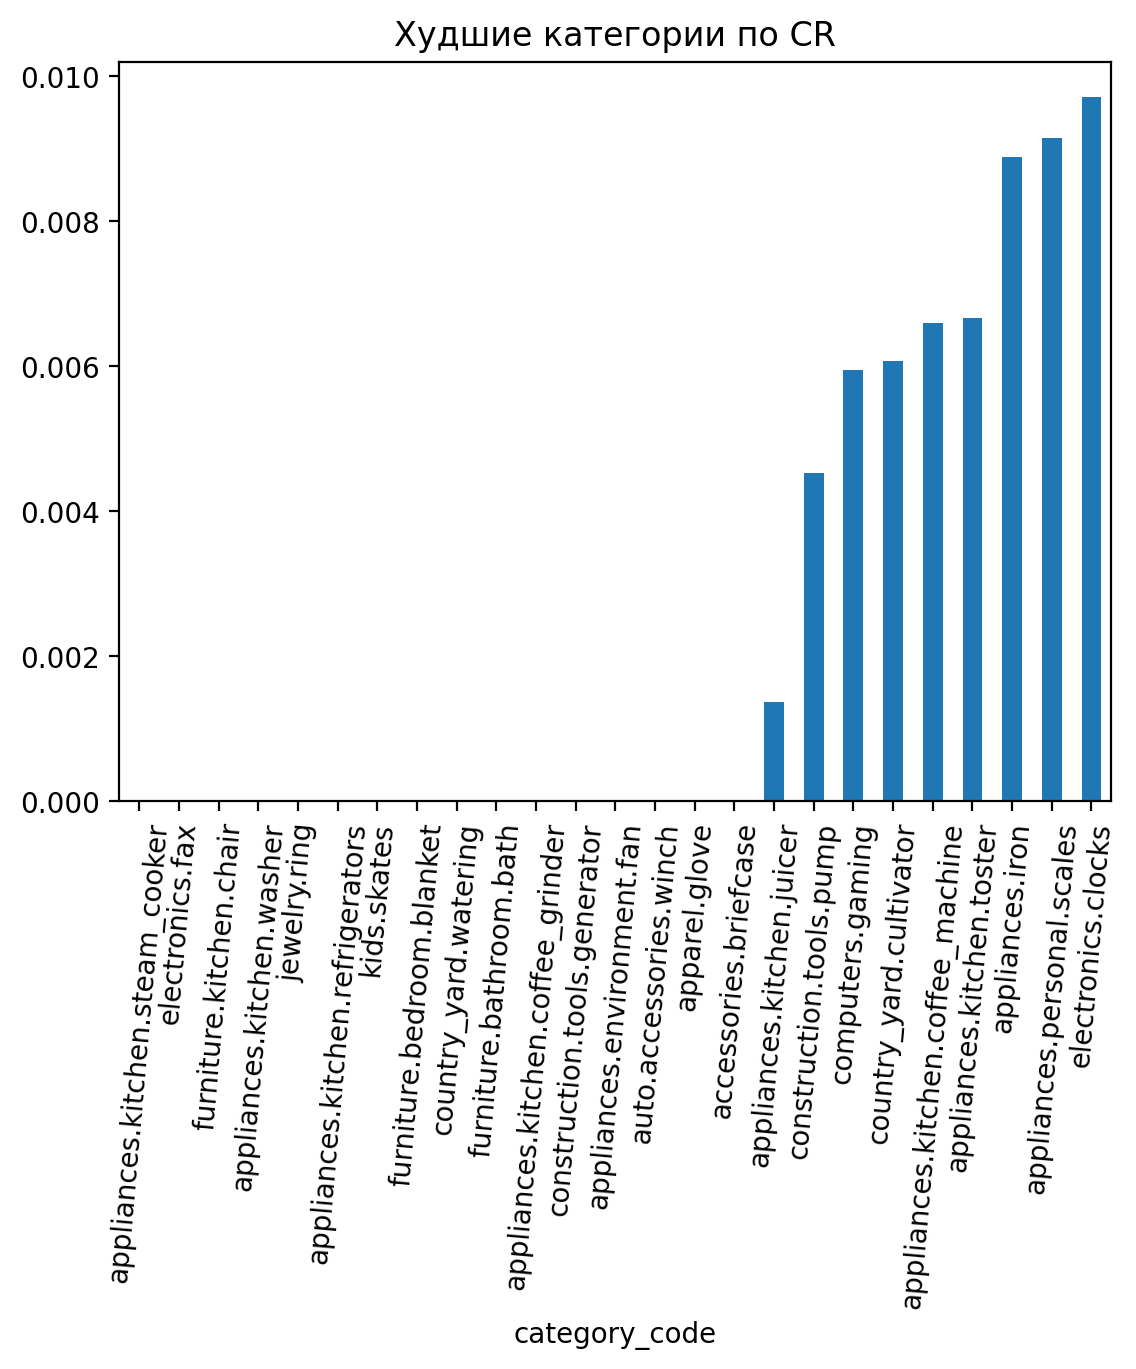

In [40]:
# Визуализация
by_cat = (funnel.groupby('category_code')
          .agg(sessions=('user_session','count'),
               purchases=('step_purchase','sum'))
          .assign(cr=lambda d: d.purchases/d.sessions)
          .sort_values('cr', ascending=True).head(25))
by_cat.cr.plot(kind='bar', title='Худшие категории по CR')
plt.xticks(rotation=85)

### Выводы и рекомендации
Стоит присмотреться к этим категориям товаров с очень маленьким или даже нулевым CR:
- Имеет смысл кратно сократить бюджет на неэффективные категории товаров.
- Вовсе не тратить бюджет на категории товаров с CR ~0%.
- Высвободившийся бюджет направить на улучшение процессов или закупку сильно более успешных категорий товаров, для более результативной конвертации бюджета в прибыль.

---
### 8. Итоговые выводы и рекомендации

**1. Качество данных**
- В исходных данных обнаружено много пропусков и дубликатов, особенно в ключевых для анализа столбцах.
- Рекомендация: регулярно проводить очистку данных, контролировать качество поступающих данных, при возможности дополнять недостающую информацию.

**2. Выбросы**
- Анализ выбросов показал наличие большого числа экстремальных цен, особенно по методу IQR. Это может указывать на ошибки при вводе или загрузке товаров.
- Рекомендация: выявлять и корректировать аномальные значения, особенно среди товаров с очень высокой ценой.

**3. Воронка продаж**
- Основная потеря пользователей происходит на этапе добавления товара в корзину. Конверсия из просмотра в корзину и из корзины в покупку низкая.
- Рекомендация: улучшить интерфейс сайта и карточек товаров, упростить процесс добавления в корзину и покупки, использовать акции и специальные предложения для повышения интереса.

**4. Категории и бренды**
- Есть категории и бренды с высокой и низкой конверсией. Некоторые категории часто просматриваются, но почти не покупаются.
- Рекомендация: фокусироваться на топовых категориях и брендах, усиливать продвижение успешных товаров, анализировать причины низкой конверсии в отдельных категориях и корректировать ассортимент или маркетинг.

**5. Оптимизация ассортимента и бюджета**
- Категории с крайне низкой конверсией требуют пересмотра: возможно, стоит сократить бюджет на их продвижение или исключить из ассортимента.
- Рекомендация: перераспределять ресурсы в пользу наиболее эффективных категорий и брендов.

**6. Общие рекомендации**
- Оптимизировать сайт и карточки товаров для повышения конверсии.
- Проводить регулярные акции и улучшать пользовательский опыт.
- Внедрять A/B-тестирование для проверки гипотез по улучшению конверсии.
- Использовать результаты анализа для принятия решений по ассортименту и